# Section 1

In [ ]:
# !wget https://archive.ics.uci.edu/static/public/179/secom.zip

In [ ]:
# !unzip secom.zip

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold

In [ ]:
SEED = 42

In [ ]:
data = pd.read_csv("secom.data", sep=" ", header=None)

print("Original shape:", data.shape)

variance_filter = VarianceThreshold(threshold=0.0)
data_var = variance_filter.fit_transform(data)

print("After removing zero-variance features:", data_var.shape)

print()

print("NaN count before imputation:", np.isnan(data_var).sum())
imputer = SimpleImputer(strategy="median")
data_imputed = imputer.fit_transform(data_var)

print("NaN count after imputation:", np.isnan(data_imputed).sum())


Original shape: (1567, 590)
After removing zero-variance features: (1567, 474)

NaN count before imputation: 41136
NaN count after imputation: 0


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_imputed)

print("Mean (first 5 features):", data_scaled.mean(axis=0)[:5])
print("Std  (first 5 features):", data_scaled.std(axis=0)[:5])


Mean (first 5 features): [ 1.62332035e-15 -5.07372631e-15 -5.71336214e-15 -1.26963603e-16
  0.00000000e+00]
Std  (first 5 features): [1. 1. 1. 1. 1.]


# Section 2

In [ ]:
import pandas as pd

y_df = pd.read_csv(
    "secom_labels.data",
    sep=" ",
    header=None,
    names=["label", "timestamp"]
)

print("Shape of labels:", y_df.shape)
y_df.head()


Shape of labels: (1567, 2)


,label,timestamp
0,-1,19/07/2008 11:55:00
1,-1,19/07/2008 12:32:00
2,1,19/07/2008 13:17:00
3,-1,19/07/2008 14:43:00
4,-1,19/07/2008 15:22:00


In [ ]:
X = data_scaled
y = y_df["label"].values

In [ ]:
from sklearn.feature_selection import mutual_info_classif
import numpy as np

mi_scores = mutual_info_classif(X, y, random_state=SEED)

mi_indices = np.argsort(mi_scores)[::-1]

top20_mi = mi_indices[:20]

print("Top 20 features (Mutual Information):")
print(top20_mi)


Top 20 features (Mutual Information):
[457 425 387 461  39  38 454 455 120 121 328  31 459 363 232  60 115 329
 333 260]


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
import time

rf = RandomForestClassifier(
    n_estimators=30,
    max_depth=12,
    random_state=SEED,
    n_jobs=-1
)

rfe = RFE(
    estimator=rf,
    n_features_to_select=20,
    step=0.3
)

start_time = time.time()

rfe.fit(X, y)

end_time = time.time()
execution_time = end_time - start_time

top20_rfe = np.where(rfe.support_)[0]

print("Top 20 features (RFE + RandomForest):")
print(top20_rfe)

print(f"Execution Time (seconds): {execution_time:.2f}")


Top 20 features (RFE + RandomForest):
[  2  23  36  54  59  60  69  92  95  96 125 143 144 187 224 357 361 387
 409 446]
Execution Time (seconds): 2.49


# Section 3

In [ ]:
import numpy as np

U, singular_values, VT = np.linalg.svd(X, full_matrices=False)

# V matrix (features x components)
V = VT.T

print("U shape:", U.shape)
print("Sigma shape:", singular_values.shape)
print("V shape:", V.shape)


U shape: (1567, 474)
Sigma shape: (474,)
V shape: (474, 474)


In [ ]:
k = 20

sigma_squared = singular_values[:k] ** 2

scores = np.zeros(V.shape[0])

for j in range(V.shape[0]):
    scores[j] = np.sum(
        sigma_squared * np.abs(V[j, :k])
    )


In [ ]:
svd_indices = np.argsort(scores)[::-1]

top20_svd = svd_indices[:20]

print("Top 20 features (SVD-based ranking):")
print(top20_svd)


Top 20 features (SVD-based ranking):
[191 188 388 287 292  68  57 258 283 184 159 224 327 360 423 284 281  43
 328 259]


# Section 4

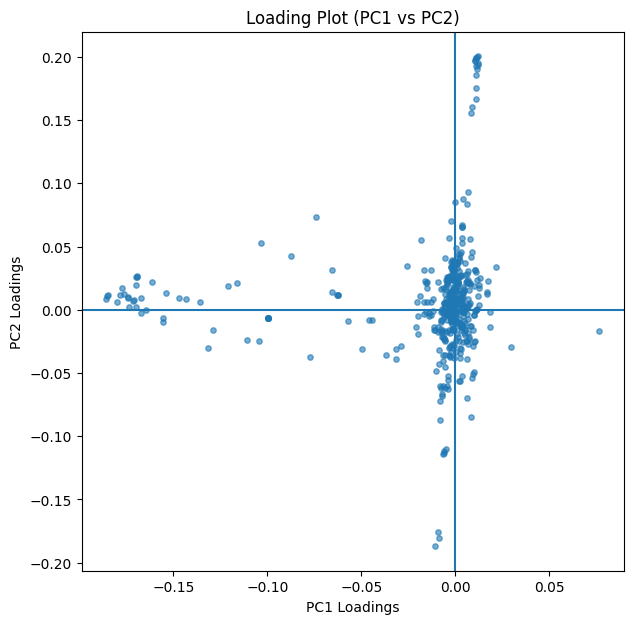

In [ ]:
import matplotlib.pyplot as plt

pc1 = V[:, 0]
pc2 = V[:, 1]

plt.figure(figsize=(7, 7))
plt.scatter(pc1, pc2, alpha=0.6, s=15)

plt.axhline(0)
plt.axvline(0)

plt.xlabel("PC1 Loadings")
plt.ylabel("PC2 Loadings")
plt.title("Loading Plot (PC1 vs PC2)")

plt.show()


In [ ]:
np.random.seed(SEED)

noise_level = 0.05
noise = noise_level * np.random.randn(*X.shape)

X_noisy = X + noise


In [ ]:
U_n, s_n, VT_n = np.linalg.svd(X_noisy, full_matrices=False)
V_n = VT_n.T

k = 20
sigma_sq_n = s_n[:k] ** 2

scores_n = np.zeros(V_n.shape[0])
for j in range(V_n.shape[0]):
    scores_n[j] = np.sum(sigma_sq_n * np.abs(V_n[j, :k]))

top20_svd_noisy = np.argsort(scores_n)[::-1][:20]


In [ ]:
rf = RandomForestClassifier(
    n_estimators=30,
    max_depth=10,
    random_state=SEED,
    n_jobs=-1
)

rfe = RFE(
    estimator=rf,
    n_features_to_select=20,
    step=0.3
)

rfe.fit(X_noisy, y)
top20_rfe_noisy = np.where(rfe.support_)[0]


In [ ]:
svd_overlap = len(set(top20_svd) & set(top20_svd_noisy))
rfe_overlap = len(set(top20_rfe) & set(top20_rfe_noisy))

print("SVD overlap:", svd_overlap, "/ 20")
print("RFE overlap:", rfe_overlap, "/ 20")


SVD overlap: 20 / 20
RFE overlap: 11 / 20


# Section 5

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import time

def evaluate_subset(X, y, feature_idx):
    X_subset = X[:, feature_idx]
    X_train, X_test, y_train, y_test = train_test_split(
        X_subset, y, test_size=0.3, random_state=42, stratify=y
    )

    clf = LogisticRegression(max_iter=1000, solver='liblinear')
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()

    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    training_time = end - start

    return acc, f1, training_time

acc_mi, f1_mi, time_mi = evaluate_subset(X, y, top20_mi)
acc_rfe, f1_rfe, time_rfe = evaluate_subset(X, y, top20_rfe)
acc_svd, f1_svd, time_svd = evaluate_subset(X, y, top20_svd)

df_results = pd.DataFrame({
    'Method': ['Mutual Information', 'RFE + RF', 'SVD-based'],
    'Accuracy': [acc_mi, acc_rfe, acc_svd],
    'F1-score': [f1_mi, f1_rfe, f1_svd],
    'Feature Selection Time (s)': [time_mi, execution_time, 0]
})

print(df_results)


               Method  Accuracy  F1-score  Feature Selection Time (s)
0  Mutual Information  0.929936  0.900268                    0.023191
1            RFE + RF  0.936306  0.911061                    2.485078
2           SVD-based  0.936306  0.907499                    0.000000


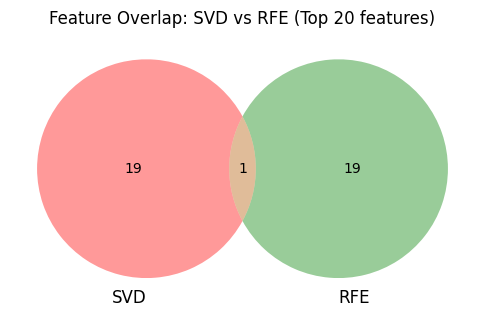

Overlap between SVD and RFE top 20 features: 5.0%


In [ ]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

set_svd = set(top20_svd)
set_rfe = set(top20_rfe)

plt.figure(figsize=(6,6))
venn2([set_svd, set_rfe], set_labels=("SVD", "RFE"))
plt.title("Feature Overlap: SVD vs RFE (Top 20 features)")
plt.show()

overlap = len(set_svd & set_rfe) / 20 * 100
print(f"Overlap between SVD and RFE top 20 features: {overlap:.1f}%")
